Total edges loaded: 20296
Largest SCC: 1294 nodes, 19026 edges
Top-N subgraph: 144 nodes, 235 edges
Number of equivalence classes under R_V^0.7: 104
Quotient graph: 104 nodes, 150 edges


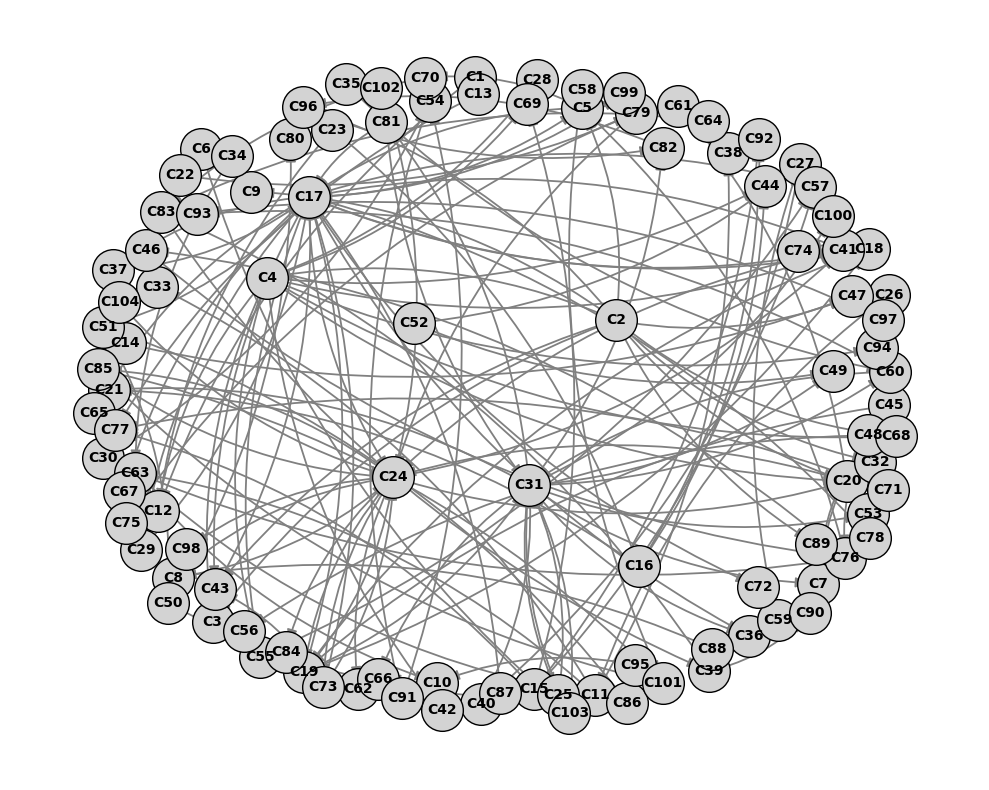

Saved Figure 1 to figure1_quotient_graph_sigma_0.7.png


In [1]:
#!/usr/bin/env python
# coding: utf-8

"""
Figure 1: Quotient graph under R_V^σ for the Facebook-like fuzzy trust network.

Pipeline
--------
1. Load facebook-wosn-links-message-weight.txt.
2. Log-normalize edge weights to [0, 1].
3. Keep the largest strongly connected component.
4. Restrict to top-N highest-weight edges and keep the largest weakly connected component.
5. Compute R_V^σ via mutual reachability with path strength >= σ.
6. Build the quotient graph F^σ = F / R_V^σ.
7. Plot the quotient graph with nodes C1, ..., Cm and directed edges.

Adjustable parameters:
- TOP_N_EDGES: controls the size of the subgraph.
- SIGMA: threshold for equivalence relation R_V^σ.
"""

import math
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ------------------------- PARAMETERS -------------------------

INPUT_FILE = "facebook-wosn-links-message-weight.txt"
OUTPUT_FIG = "figure1_quotient_graph_sigma_0.7.png"

TOP_N_EDGES = 300   # try 200–400 for a moderate subgraph
SIGMA = 0.7         # threshold σ for R_V^σ

# --------------------------------------------------------------
# 1. Load and log-normalize weights
# --------------------------------------------------------------

df = pd.read_csv(
    INPUT_FILE,
    sep=r"\s+",
    header=None,
    names=["source", "target", "weight"],
)
print(f"Total edges loaded: {len(df)}")

# log-normalization to [0,1]
df["weight_log"] = df["weight"].apply(lambda w: math.log1p(w))
max_log = df["weight_log"].max()
df["weight_norm"] = df["weight_log"] / max_log

# --------------------------------------------------------------
# 2. Build directed fuzzy graph and take largest SCC
# --------------------------------------------------------------

G_full = nx.DiGraph()
for _, row in df.iterrows():
    G_full.add_edge(row["source"], row["target"], weight=row["weight_norm"])

if not nx.is_strongly_connected(G_full):
    largest_scc = max(nx.strongly_connected_components(G_full), key=len)
    G_scc = G_full.subgraph(largest_scc).copy()
else:
    G_scc = G_full

print(f"Largest SCC: {G_scc.number_of_nodes()} nodes, {G_scc.number_of_edges()} edges")

# --------------------------------------------------------------
# 3. Restrict to top-N edges and largest weakly connected component
# --------------------------------------------------------------

# select top-N edges by normalized weight
edges_sorted = sorted(
    G_scc.edges(data=True),
    key=lambda x: x[2]["weight"],
    reverse=True,
)
top_edges = edges_sorted[:TOP_N_EDGES]

G_top = nx.DiGraph()
for u, v, d in top_edges:
    G_top.add_edge(u, v, weight=d["weight"])

if not nx.is_weakly_connected(G_top):
    largest_wcc = max(nx.weakly_connected_components(G_top), key=len)
    G_top = G_top.subgraph(largest_wcc).copy()

print(f"Top-N subgraph: {G_top.number_of_nodes()} nodes, {G_top.number_of_edges()} edges")

# --------------------------------------------------------------
# 4. Compute R_V^σ via thresholded reachability
#    s(u→v) ≥ σ  ⇔  there exists a path from u to v whose
#    minimal edge weight along the path is ≥ σ.
#    We realize this by BFS restricted to edges with weight ≥ σ.
# --------------------------------------------------------------

from collections import deque

sigma = SIGMA
nodes = list(G_top.nodes())

# reachable_sigma[u] = set of v with s(u→v) ≥ σ (v ≠ u)
reachable_sigma = {}

for source in nodes:
    visited = set()
    queue = deque([source])
    while queue:
        u = queue.popleft()
        for v in G_top.successors(u):
            w = G_top[u][v]["weight"]
            if w >= sigma and v not in visited and v != source:
                visited.add(v)
                queue.append(v)
    reachable_sigma[source] = visited

# Equivalence classes: u ~ v iff u→v and v→u with strength ≥ σ
unseen = set(nodes)
equiv_classes = []

while unseen:
    u = unseen.pop()
    current_class = {u}
    to_merge = set()
    for v in list(unseen):
        if (v in reachable_sigma[u]) and (u in reachable_sigma[v]):
            to_merge.add(v)
    current_class.update(to_merge)
    unseen.difference_update(to_merge)
    equiv_classes.append(current_class)

print(f"Number of equivalence classes under R_V^{sigma}: {len(equiv_classes)}")

# mapping: original vertex -> class index
node_to_class = {}
for idx, cls in enumerate(equiv_classes):
    for x in cls:
        node_to_class[x] = idx

# --------------------------------------------------------------
# 5. Build quotient graph F^σ = F / R_V^σ
#    Node i corresponds to class C_i.
#    Edge weight is max of weights between classes.
# --------------------------------------------------------------

Q = nx.DiGraph()

# add quotient nodes
for i, cls in enumerate(equiv_classes):
    Q.add_node(i, members=sorted(cls))

# aggregate edges
for u, v, d in G_top.edges(data=True):
    cu = node_to_class[u]
    cv = node_to_class[v]
    if cu == cv:
        continue
    w = d["weight"]
    if Q.has_edge(cu, cv):
        if w > Q[cu][cv]["weight"]:
            Q[cu][cv]["weight"] = w
    else:
        Q.add_edge(cu, cv, weight=w)

print(f"Quotient graph: {Q.number_of_nodes()} nodes, {Q.number_of_edges()} edges")

# --------------------------------------------------------------
# 6. Plot quotient graph (Figure 1)
# --------------------------------------------------------------

plt.figure(figsize=(10, 8))

# layout (spring_layout is portable; you can swap to graphviz_layout if desired)
pos = nx.spring_layout(Q, seed=42, k=1.5)

# node labels C1, C2, ...
labels_nodes = {i: f"C{i+1}" for i in Q.nodes()}

nx.draw_networkx_nodes(Q, pos, node_color="lightgray", node_size=900, edgecolors="black")
nx.draw_networkx_labels(Q, pos, labels=labels_nodes, font_size=10, font_weight="bold")

# directed edges with mild curvature
nx.draw_networkx_edges(
    Q,
    pos,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=15,
    width=1.3,
    connectionstyle="arc3,rad=0.15",
    edge_color="gray",
)

# optional: show edge weights (comment out if you prefer a cleaner figure)
# edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in Q.edges(data=True)}
# nx.draw_networkx_edge_labels(Q, pos, edge_labels=edge_labels, font_size=8)

plt.axis("off")
plt.tight_layout()
plt.savefig(OUTPUT_FIG, dpi=300)
plt.show()

print(f"Saved Figure 1 to {OUTPUT_FIG}")


Loading data...
Total edges loaded: 20296
weight_min=0.30: graph with 1056 nodes, 6083 edges.
  sigma=0.30: 275 equivalence classes.
  sigma=0.40: 600 equivalence classes.
  sigma=0.50: 761 equivalence classes.
  sigma=0.60: 928 equivalence classes.
  sigma=0.70: 1005 equivalence classes.
  sigma=0.80: 1039 equivalence classes.
weight_min=0.35: graph with 866 nodes, 4097 edges.
  sigma=0.30: 209 equivalence classes.
  sigma=0.40: 410 equivalence classes.
  sigma=0.50: 571 equivalence classes.
  sigma=0.60: 738 equivalence classes.
  sigma=0.70: 815 equivalence classes.
  sigma=0.80: 849 equivalence classes.
weight_min=0.40: graph with 658 nodes, 2269 edges.
  sigma=0.30: 204 equivalence classes.
  sigma=0.40: 204 equivalence classes.
  sigma=0.50: 364 equivalence classes.
  sigma=0.60: 530 equivalence classes.
  sigma=0.70: 607 equivalence classes.
  sigma=0.80: 641 equivalence classes.
weight_min=0.45: graph with 563 nodes, 1786 edges.
  sigma=0.30: 184 equivalence classes.
  sigma=0.

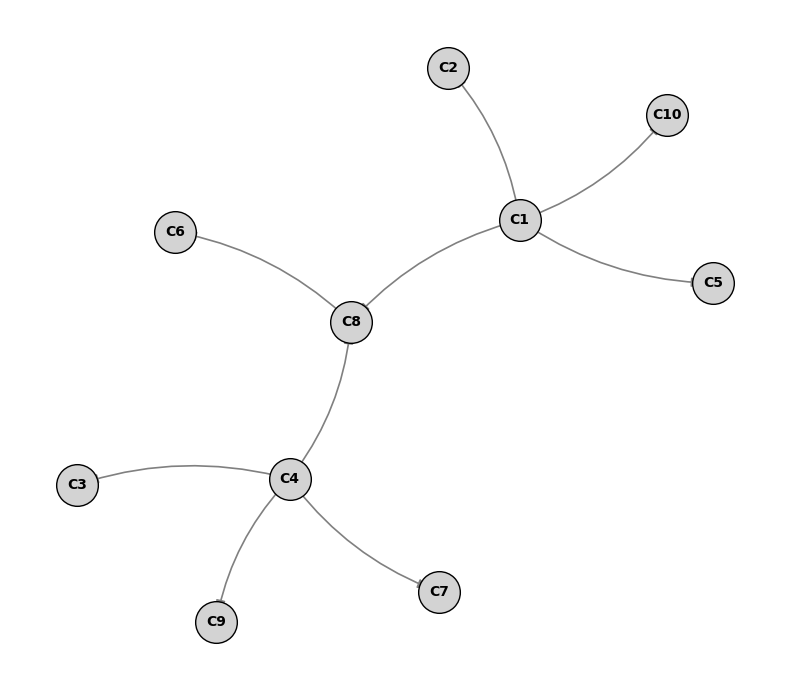


Saved adaptive quotient graph figure to figure1_quotient_graph_adaptive.png


In [3]:
#!/usr/bin/env python
# coding: utf-8

import math
from collections import deque

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

INPUT_FILE = "facebook-wosn-links-message-weight.txt"
OUTPUT_FIG = "figure1_quotient_graph_adaptive.png"

# Extended grids
WEIGHT_MIN_GRID = (
    [round(x, 2) for x in [0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65]]
    + [round(x, 2) for x in [0.70, 0.75, 0.80, 0.85, 0.90, 0.95]]
)

SIGMA_GRID = [0.30, 0.40, 0.50, 0.60, 0.70, 0.80]

MIN_CLASSES = 10
MAX_CLASSES = 20
TARGET_CLASSES = 14

LAYOUT_SEED = 42

print("Loading data...")
df = pd.read_csv(
    INPUT_FILE,
    sep=r"\s+",
    header=None,
    names=["source", "target", "weight"],
)
print(f"Total edges loaded: {len(df)}")

df["weight_log"] = df["weight"].apply(lambda w: math.log1p(w))
max_log = df["weight_log"].max()
df["weight_norm"] = df["weight_log"] / max_log


def build_graph_from_threshold(weight_min: float) -> nx.DiGraph | None:
    df_f = df[df["weight_norm"] >= weight_min].copy()
    if df_f.empty:
        return None

    G = nx.DiGraph()
    for _, row in df_f.iterrows():
        G.add_edge(row["source"], row["target"], weight=row["weight_norm"])

    if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
        return None

    if not nx.is_weakly_connected(G):
        largest_wcc = max(nx.weakly_connected_components(G), key=len)
        G = G.subgraph(largest_wcc).copy()

    return G


def sigma_reachability_classes(G: nx.DiGraph, sigma: float):
    nodes = list(G.nodes())
    if len(nodes) == 0:
        return []

    reachable = {}
    for s in nodes:
        visited = set()
        q = deque([s])
        while q:
            u = q.popleft()
            for v in G.successors(u):
                w = G[u][v]["weight"]
                if w >= sigma and v not in visited and v != s:
                    visited.add(v)
                    q.append(v)
        reachable[s] = visited

    unseen = set(nodes)
    classes = []
    while unseen:
        u = unseen.pop()
        current = {u}
        to_merge = set()
        for v in list(unseen):
            if (v in reachable[u]) and (u in reachable[v]):
                to_merge.add(v)
        current.update(to_merge)
        unseen.difference_update(to_merge)
        classes.append(current)

    return classes


def build_quotient_graph(G: nx.DiGraph, classes):
    Q = nx.DiGraph()
    node_to_class = {}

    for idx, cls in enumerate(classes):
        for x in cls:
            node_to_class[x] = idx
        Q.add_node(idx, members=sorted(cls))

    for u, v, d in G.edges(data=True):
        cu = node_to_class[u]
        cv = node_to_class[v]
        if cu == cv:
            continue
        w = d["weight"]
        if Q.has_edge(cu, cv):
            if w > Q[cu][cv]["weight"]:
                Q[cu][cv]["weight"] = w
        else:
            Q.add_edge(cu, cv, weight=w)

    return Q


best_in_range = None      # (score, w_min, sigma, classes, G, Q)
best_overall = None       # (num_classes, w_min, sigma, classes, G, Q)

for w_min in WEIGHT_MIN_GRID:
    G = build_graph_from_threshold(w_min)
    if G is None:
        print(f"weight_min={w_min:.2f}: empty graph, skipping.")
        continue

    print(f"weight_min={w_min:.2f}: graph with {G.number_of_nodes()} nodes, "
          f"{G.number_of_edges()} edges.")

    for sigma in SIGMA_GRID:
        classes = sigma_reachability_classes(G, sigma)
        num_classes = len(classes)
        if num_classes == 0:
            continue

        print(f"  sigma={sigma:.2f}: {num_classes} equivalence classes.")

        # track best overall (fewest classes)
        if best_overall is None or num_classes < best_overall[0]:
            Q = build_quotient_graph(G, classes)
            best_overall = (num_classes, w_min, sigma, classes, G, Q)

        # track best within desired range
        if MIN_CLASSES <= num_classes <= MAX_CLASSES:
            score = abs(num_classes - TARGET_CLASSES)
            if (best_in_range is None) or (score < best_in_range[0]):
                Q = build_quotient_graph(G, classes)
                best_in_range = (score, w_min, sigma, classes, G, Q)

# Choose configuration
if best_in_range is not None:
    _, best_w_min, best_sigma, classes, G_best, Q_best = best_in_range
    print("\nSelected configuration (within 10–20 classes):")
    print(f"  weight_min = {best_w_min:.2f}")
    print(f"  sigma      = {best_sigma:.2f}")
    print(f"  |V(G_best)| = {G_best.number_of_nodes()}")
    print(f"  |E(G_best)| = {G_best.number_of_edges()}")
    print(f"  #classes    = {len(classes)}")
else:
    num_classes, best_w_min, best_sigma, classes, G_best, Q_best = best_overall
    print("\nNo configuration in [10,20] classes.")
    print("Using configuration with the smallest number of classes instead:")
    print(f"  weight_min = {best_w_min:.2f}")
    print(f"  sigma      = {best_sigma:.2f}")
    print(f"  |V(G_best)| = {G_best.number_of_nodes()}")
    print(f"  |E(G_best)| = {G_best.number_of_edges()}")
    print(f"  #classes    = {num_classes}")

# Plot quotient graph
try:
    from networkx.drawing.nx_agraph import graphviz_layout
    pos = graphviz_layout(Q_best, prog="neato")
except Exception:
    pos = nx.spring_layout(Q_best, seed=LAYOUT_SEED, k=1.5)

plt.figure(figsize=(8, 7))

labels_nodes = {i: f"C{i+1}" for i in Q_best.nodes()}

nx.draw_networkx_nodes(
    Q_best,
    pos,
    node_color="lightgray",
    node_size=900,
    edgecolors="black",
    linewidths=1.0,
)
nx.draw_networkx_labels(
    Q_best,
    pos,
    labels=labels_nodes,
    font_size=10,
    font_weight="bold",
)
nx.draw_networkx_edges(
    Q_best,
    pos,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=14,
    width=1.2,
    connectionstyle="arc3,rad=0.15",
    edge_color="gray",
)

plt.axis("off")
plt.tight_layout()
plt.savefig(OUTPUT_FIG, dpi=300)
plt.show()

print(f"\nSaved adaptive quotient graph figure to {OUTPUT_FIG}")


Loading data...
Total edges loaded: 20296
Filtered graph G: 11 nodes, 11 edges
#equivalence classes under R_V^0.5 = 10
Quotient graph Q: 10 nodes, 9 edges


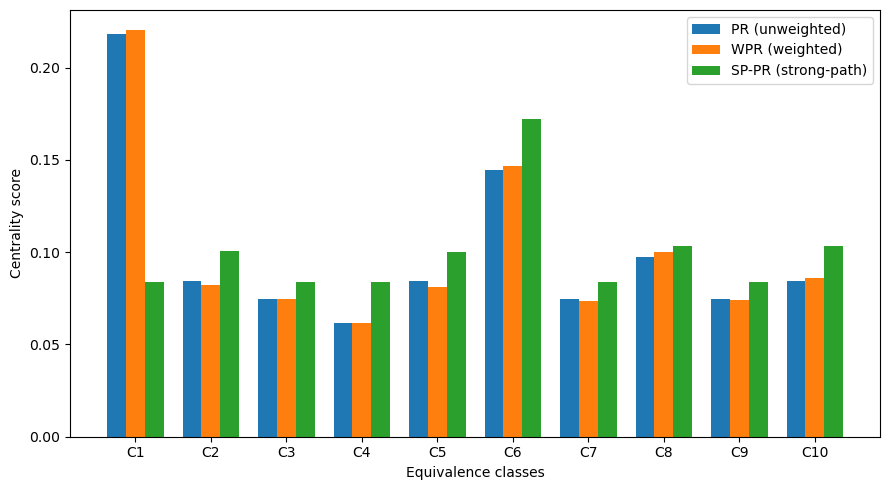

Saved Figure 2 to Figure2_PR_WPR_SPPR_QGA10.png


In [4]:
#!/usr/bin/env python
# coding: utf-8

import math
from collections import deque, defaultdict

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


INPUT_FILE = "facebook-wosn-links-message-weight.txt"
OUTPUT_FIG = "Figure2_PR_WPR_SPPR_QGA10.png"

WEIGHT_MIN = 0.75   # edge threshold
SIGMA = 0.50        # strong-path equivalence parameter
ALPHA = 0.85        # damping factor for all PageRank variants
LAYOUT_SEED = 42    # not used here, but kept for consistency


# ---------------------- 1. Load and normalize weights ----------------------

print("Loading data...")
df = pd.read_csv(
    INPUT_FILE,
    sep=r"\s+",
    header=None,
    names=["source", "target", "weight"],
)
print(f"Total edges loaded: {len(df)}")

df["weight_log"] = df["weight"].apply(lambda w: math.log1p(w))
max_log = df["weight_log"].max()
df["weight_norm"] = df["weight_log"] / max_log


# ---------------------- 2. Build filtered graph (weight_min) --------------

df_f = df[df["weight_norm"] >= WEIGHT_MIN].copy()
if df_f.empty:
    raise RuntimeError("No edges above WEIGHT_MIN; adjust threshold.")

G = nx.DiGraph()
for _, row in df_f.iterrows():
    G.add_edge(row["source"], row["target"], weight=row["weight_norm"])

if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
    raise RuntimeError("Filtered graph is empty; adjust thresholds.")

if not nx.is_weakly_connected(G):
    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    G = G.subgraph(largest_wcc).copy()

print(f"Filtered graph G: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


# ---------------------- 3. Equivalence classes R_V^sigma ------------------

def equivalence_classes(G: nx.DiGraph, sigma: float):
    nodes = list(G.nodes())
    if not nodes:
        return []

    reachable = {}
    for s in nodes:
        visited = set()
        q = deque([s])
        while q:
            u = q.popleft()
            for v in G.successors(u):
                w = G[u][v]["weight"]
                if w >= sigma and v not in visited and v != s:
                    visited.add(v)
                    q.append(v)
        reachable[s] = visited

    unseen = set(nodes)
    classes = []
    while unseen:
        u = unseen.pop()
        current = {u}
        to_merge = set()
        for v in list(unseen):
            if (v in reachable[u]) and (u in reachable[v]):
                to_merge.add(v)
        current.update(to_merge)
        unseen.difference_update(to_merge)
        classes.append(current)

    return classes

classes = equivalence_classes(G, SIGMA)
print(f"#equivalence classes under R_V^{SIGMA} = {len(classes)}")
if len(classes) != 10:
    print("Warning: expected 10 classes; got", len(classes))

# mapping vertex -> class index
node_to_class = {}
for idx, cls in enumerate(classes):
    for x in cls:
        node_to_class[x] = idx


# ---------------------- 4. Build quotient graph QGA_10 --------------------

Q = nx.DiGraph()
for idx, cls in enumerate(classes):
    Q.add_node(idx, members=sorted(cls))

for u, v, d in G.edges(data=True):
    cu = node_to_class[u]
    cv = node_to_class[v]
    if cu == cv:
        continue
    w = d["weight"]
    if Q.has_edge(cu, cv):
        if w > Q[cu][cv]["weight"]:
            Q[cu][cv]["weight"] = w
    else:
        Q.add_edge(cu, cv, weight=w)

print(f"Quotient graph Q: {Q.number_of_nodes()} nodes, {Q.number_of_edges()} edges")


# ---------------------- 5. PageRank on original graph (PR, WPR) -----------

# (a) classical PageRank – unweighted random walk
pr_vertex = nx.pagerank(G, alpha=ALPHA, weight=None)

# (b) weighted PageRank – weights used as transition intensities
wpr_vertex = nx.pagerank(G, alpha=ALPHA, weight="weight")

# aggregate to class level by summing over members
m = len(classes)
pr_class = np.zeros(m)
wpr_class = np.zeros(m)
for v in G.nodes():
    c = node_to_class[v]
    pr_class[c] += pr_vertex[v]
    wpr_class[c] += wpr_vertex[v]


# ---------------------- 6. Strong-path PageRank on Q ----------------------

nodes_Q = sorted(Q.nodes())
idx_map = {c: i for i, c in enumerate(nodes_Q)}
m = len(nodes_Q)

# --- (6a) Compute vertex memberships mu(v) on G ---
mu = {}
for v in G.nodes():
    in_edges = list(G.in_edges(v, data=True))
    if in_edges:
        mu[v] = max(d["weight"] for _, _, d in in_edges)
    else:
        mu[v] = 0.0  # or a small epsilon if you prefer

# --- (6b) Class-level memberships \bar{\mu}(C_i) ---
mu_bar = np.zeros(m)
for idx, cls in enumerate(classes):
    mu_bar[idx] = max(mu[v] for v in cls)

# --- (6c) Treat Q edge weights as m_{ij} and clamp to w_{ij} = \bar{\lambda}(C_i, C_j) ---
W = np.zeros((m, m), dtype=float)  # W will store w_{ij} = \bar{\lambda}(C_i, C_j)

for u, v, d in Q.edges(data=True):
    i = idx_map[u]
    j = idx_map[v]
    m_ij = d["weight"]                     # hyperop-incidence-like coefficient
    w_ij = min(mu_bar[i], mu_bar[j], m_ij) # clamped edge membership
    W[i, j] = w_ij

# --- (6d) Row-normalize to get P (dangling handled by teleportation or fill) ---
row_sums = W.sum(axis=1)
P = np.zeros_like(W)
for i in range(m):
    if row_sums[i] > 0:
        P[i, :] = W[i, :] / row_sums[i]
    else:
        # Dangling class: use uniform distribution (or u_vec if non-uniform teleportation)
        P[i, :] = 1.0 / m


# --- (6e) Strong-path PageRank: p = α P^T p + (1-α) u, with uniform u ---
u_vec = np.ones(m) / m
I = np.eye(m)
p_sp = np.linalg.solve(I - ALPHA * P.T, (1 - ALPHA) * u_vec)

sppr_class = p_sp  # already aligned with class indices 0..m-1


# ---------------------- 7. Bar plot ---------------------------------------

labels = [f"C{i+1}" for i in range(m)]
x = np.arange(m)
width = 0.25

plt.figure(figsize=(9, 5))

plt.bar(x - width, pr_class,  width, label="PR (unweighted)")
plt.bar(x,         wpr_class, width, label="WPR (weighted)")
plt.bar(x + width, sppr_class, width, label="SP-PR (strong-path)")

plt.xticks(x, labels)
plt.ylabel("Centrality score")
plt.xlabel("Equivalence classes")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(OUTPUT_FIG, dpi=900)
plt.show()

print(f"Saved Figure 2 to {OUTPUT_FIG}")


In [6]:
import seaborn as sns


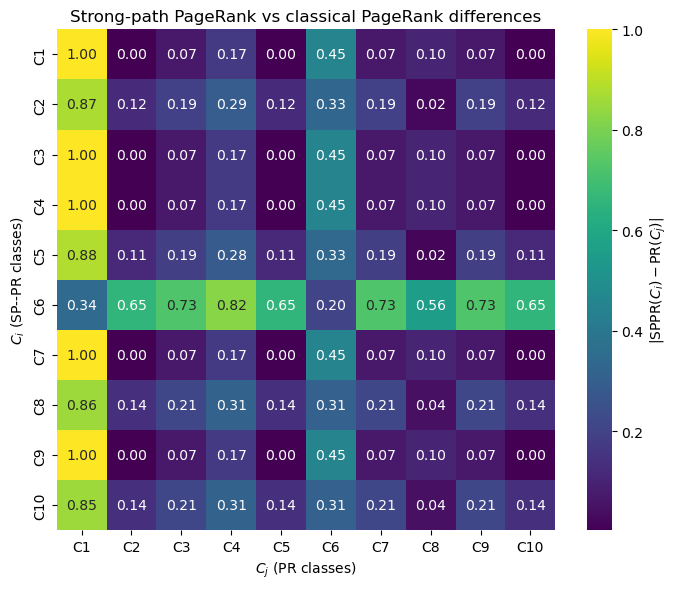

Saved Figure 3 to Figure3_SPPR_vs_PR_Heatmap.png


In [7]:
# ==================== FIGURE 3: SP-PR vs PR HEATMAP ====================

# Compute absolute differences matrix D_{ij} = |SPPR(C_i) - PR(C_j)|
m = len(pr_class)
D = np.abs(sppr_class.reshape(m, 1) - pr_class.reshape(1, m))

# Normalize to [0,1] for plotting (optional, but matches LaTeX caption)
D_norm = D / D.max() if D.max() > 0 else D

# Build DataFrame for seaborn
df_diff = pd.DataFrame(D_norm, index=labels, columns=labels)

plt.figure(figsize=(7, 6))
ax = sns.heatmap(
    df_diff,
    annot=True,         # show numeric differences
    fmt=".2f",
    cmap="viridis",
    cbar_kws={"label": r"$|\mathrm{SPPR}(C_i) - \mathrm{PR}(C_j)|$"}
)

ax.set_xlabel(r"$C_j$ (PR classes)")
ax.set_ylabel(r"$C_i$ (SP--PR classes)")
ax.set_title("Strong-path PageRank vs classical PageRank differences")

plt.tight_layout()
plt.savefig("Figure3_SPPR_vs_PR_Heatmap.png", dpi=900)
plt.show()

print("Saved Figure 3 to Figure3_SPPR_vs_PR_Heatmap.png")


In [2]:
print("PR class:", pr_class)
print("WPR class:", wpr_class)
print("SPPR class:", sppr_class)
print("max |SPPR - WPR|:", np.max(np.abs(sppr_class - wpr_class)))
print("max |SPPR - PR| :", np.max(np.abs(sppr_class - pr_class)))


PR class: [0.21799259 0.08445377 0.07487486 0.06175248 0.08445377 0.14469289
 0.07487486 0.09757615 0.07487486 0.08445377]
WPR class: [0.22018378 0.08238409 0.07440863 0.06141016 0.08115462 0.1465448
 0.07350247 0.10015723 0.07405103 0.08620319]
SPPR class: [0.015      0.01799087 0.015      0.015      0.01781554 0.03069298
 0.015      0.01846233 0.015      0.01848126]
max |SPPR - WPR|: 0.205183777255379
max |SPPR - PR| : 0.2029925924027371


In [3]:
P = np.zeros((m, m), dtype=float)
for u, v, d in Q.edges(data=True):
    i = idx_map[u]
    j = idx_map[v]
    P[i, j] = d["weight"]

row_sums = P.sum(axis=1)
for i in range(m):
    if row_sums[i] > 0:
        P[i, :] /= row_sums[i]
    else:
        # dangling class: teleport uniformly
        P[i, :] = 1.0 / m

# strong-path PageRank: p = α P^T p + (1-α) u, with uniform u
u_vec = np.ones(m) / m
I = np.eye(m)
p_sp = np.linalg.solve(I - ALPHA * P.T, (1 - ALPHA) * u_vec)

sppr_class = p_sp
print("sum(PR_class)  =", pr_class.sum())
print("sum(WPR_class) =", wpr_class.sum())
print("sum(SPPR_class)=", sppr_class.sum())


sum(PR_class)  = 1.0
sum(WPR_class) = 1.0
sum(SPPR_class)= 0.9999999999999998
